# Plot map of snow disappearance dates
*J. Michelle Hu  
University of Utah  
August 2024*  
---

In [1]:
import os
import sys
import xarray as xr
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
import processing as proc
import datetime

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# Set environmental variable for PROJ to directory where you can find proj.db
os.environ['PROJ']='/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj'
os.environ['PROJLIB']='/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj'

## Directory

In [4]:
# basin = 'blue_river'
# basin = 'yampa'
basin = 'animas'

In [5]:
workdir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/'
basindirs = h.fn_list(workdir, f'__{basin}*')
basindirs

['/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/__animas_100m_isnobal',
 '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/__animas_100m_isnobal_solar_albedo']

In [6]:
# Get the WY from the directory name
WY = int(h.fn_list(basindirs[0], '*')[0].split('/')[-1].split('wy')[-1])
WY

2021

In [7]:
basindirs[0]

'/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/__animas_100m_isnobal'

In [8]:
# from daily netcdf files for a water year, read in snow depth data, calculate SDD, and return the date for each pixel within the domain (i.e., basin)
nc_list = h.fn_list(basindirs[0], f'*{WY}/*/*/snow.nc')
len(nc_list)

350

In [9]:
%%time
ds_list = [np.squeeze(xr.open_dataset(nc)['thickness']) for nc in nc_list]

CPU times: user 4.08 s, sys: 3.25 s, total: 7.32 s
Wall time: 11.1 s


In [10]:
len(ds_list)

350

In [11]:
ds_list[0]

<xarray.DataArray 'thickness' (y: 820, x: 492)> Size: 2MB
[403440 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 8B 2020-10-01T22:00:00
  * y        (y) float32 3kB 4.205e+06 4.205e+06 ... 4.123e+06 4.123e+06
  * x        (x) float32 2kB 2.299e+05 2.3e+05 2.301e+05 ... 2.789e+05 2.79e+05
Attributes:
    units:         m
    description:   Predicted thickness of the snowcover
    grid_mapping:  projection

In [12]:
%%time
# Concatenate the list of xarray datasets into a single xarray dataset
ds = xr.concat(ds_list, dim='time')

CPU times: user 2.75 s, sys: 4.04 s, total: 6.8 s
Wall time: 10.3 s


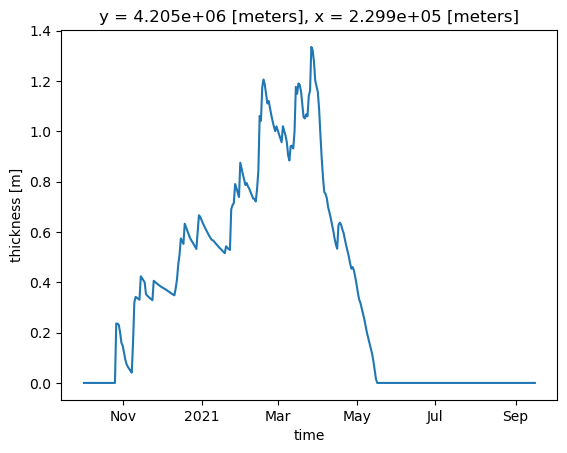

In [13]:
ds[:,0,0].plot()

In [14]:
sdd, deriv = proc.calc_sdd(ds[:,0,0].to_series())
sdd

Timestamp('2021-05-14 22:00:00')

In [15]:
def calc_sdd(snow_property, verbose=False, snow_name=None, day_thresh=10):
    '''
    Calculate snow disappearance date from a pandas series of snow depth or SWE.
    
    Args:
        snow_property (pandas.Series): A pandas series of snow depth or SWE (measurement units in meters).
        verbose (bool, optional): If True, print additional information. Defaults to False.
        snow_name (str, optional): Name of the snow property. Defaults to None.
    
    Returns:
        tuple: A tuple containing the snow disappearance date and the first derivative of the snow property.
    
    Notes:
        - This function calculates the first derivative of the snow property and expects input units of meters.
        - It determines the last date at which the derivative is nonzero , which represents the snow disappearance date.
        - This method is robust to a definable threshold (day_thresh), where the preceding sequential days must also have negative derivatives
    
    Modified from https://stackoverflow.com/questions/22000882/find-last-non-zero-elements-index-in-pandas-series
    '''
    # Calculate first derivative of snow property
    firstderiv = snow_property.diff() / snow_property.index.to_series().diff().dt.total_seconds()

    # Get list of dates with negative derivatives (declining snow property)
    # deriv_dates = firstderiv[firstderiv < -1e-7]
    deriv_dates = firstderiv[firstderiv < 0]

    # Determine last date at which derivative is robustly negative, starting with the last date in the series
    snow_all_test_date = deriv_dates.index[-1]
    counter = 0
    if verbose: 
        print(f'Starting snow all gone date: {snow_all_test_date}')

    # Loop through all dates where the first derivative is negative
    for f in range(-2, -len(deriv_dates), -1):
        preceding_date = deriv_dates.index[f-1]
        if verbose:
            print(snow_all_test_date, preceding_date)
        
        # If the preceding date is not the date before, reset the counter,
        # otherwise increment the counter
        if snow_all_test_date - preceding_date != datetime.timedelta(days=1):    
            if verbose: 
                print('Did not pass test, resetting counter')
            counter = 0
        else:
            counter+=1
        
        # Reassign snow_all_test_date to preceding date value
        snow_all_test_date = preceding_date

        # If the counter exceeds the sequential days threshold, 
        # break the loop and readjust the index to the now robustly found date
        if counter >= day_thresh:
            snow_all_gone_date = deriv_dates.index[f+counter-1]
            # print(f, counter)
            if verbose: 
                print(f'Found snow all gone date: {snow_all_gone_date}')
            break
        # print(f'{counter}\n')
    
    if verbose:
        print(f'Snow all gone date {snow_all_gone_date.strftime('%Y-%m-%d')}')
        print(f'Derivative: {firstderiv.loc[snow_all_gone_date]*86400} m/d')
        if snow_name is None:
            snow_name = 'Snow property value'
        print(f'{snow_name}: {snow_property.loc[snow_all_gone_date]} m')
    
    return snow_all_gone_date, firstderiv

In [16]:
# Chop to test
ds_crop = ds.isel(x=slice(0, 10), y=slice(0, 20))
sdd, _ = calc_sdd(ds_crop[:,0,0].to_series())
sdd

Timestamp('2021-05-14 22:00:00')

In [17]:
import copy
# Create an empty dataset of the same x and y dims to store the SDD values
sdd_ds = copy.deepcopy(ds_crop.isel(time=0))
sdd_arr = sdd_ds.data
sdd_arr.shape

(20, 10)

In [18]:
%%time
# fill the array with the sdd value
for i in range(ds_crop.x.size):
    for j in range(ds_crop.y.size):
        sdd, _ = calc_sdd(ds_crop[:,j, i].to_series())
        sdd_arr[j, i] = sdd.timestamp()

sdd_ds.data = sdd_arr

CPU times: user 266 ms, sys: 203 µs, total: 266 ms
Wall time: 267 ms


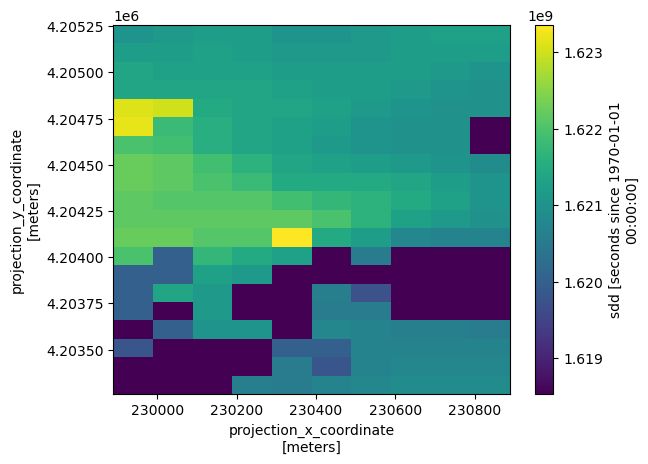

In [19]:
# Update var name and attributes
sdd_ds.name = 'sdd'
sdd_ds.attrs['units'] = 'seconds since 1970-01-01 00:00:00'
sdd_ds.attrs['description'] = 'snow disappearance date for each pixel in the domain'
# remove the time coordintaes
sdd_ds = sdd_ds.drop_vars('time')
sdd_ds.plot()

(820, 492)
CPU times: user 7min 57s, sys: 88.1 ms, total: 7min 57s
Wall time: 8min


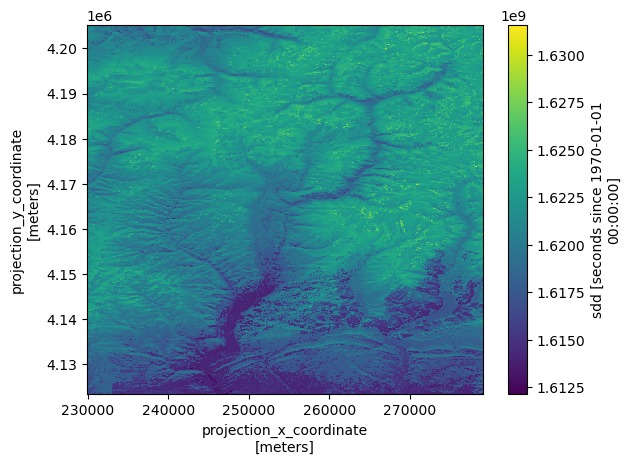

In [20]:
%%time
# Now do it for the whole thing

# Create an empty dataset of the same x and y dims to store the SDD values
sdd_ds = copy.deepcopy(ds.isel(time=0))
sdd_arr = sdd_ds.data
print(sdd_arr.shape)


# fill the array with the sdd value
for i in range(ds.x.size):
    for j in range(ds.y.size):
        sdd, _ = proc.calc_sdd(ds[:,j,i].to_series(), day_thresh=2)
        sdd_arr[j, i] = sdd.timestamp()

sdd_ds.data = sdd_arr

# Update var name and attributes
sdd_ds.name = 'sdd'
sdd_ds.attrs['units'] = 'seconds since 1970-01-01 00:00:00'
sdd_ds.attrs['description'] = 'snow disappearance date for each pixel in the domain'
# remove the time coordinates
sdd_ds = sdd_ds.drop_vars('time')

# and plot
sdd_ds.plot()


In [21]:
# Convert back to date
sdd_date_ds = sdd_ds.to_dataset()
sdd_date_ds['sdd'] = sdd_date_ds['sdd'].astype('datetime64[s]')
sdd_date_ds

/scratch/local/u6058223/ipykernel_660268/870938175.py:3: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  sdd_date_ds['sdd'] = sdd_date_ds['sdd'].astype('datetime64[s]')


<xarray.Dataset> Size: 3MB
Dimensions:  (y: 820, x: 492)
Coordinates:
  * y        (y) float32 3kB 4.205e+06 4.205e+06 ... 4.123e+06 4.123e+06
  * x        (x) float32 2kB 2.299e+05 2.3e+05 2.301e+05 ... 2.789e+05 2.79e+05
Data variables:
    sdd      (y, x) datetime64[ns] 3MB 2021-05-14T22:00:32 ... 2021-03-11T22:...

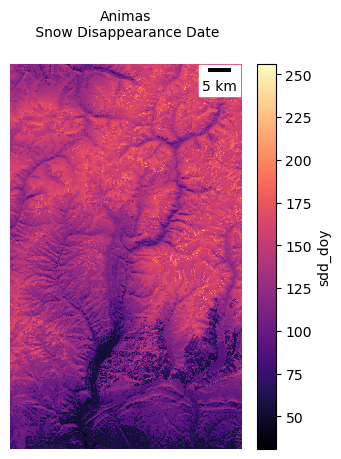

In [22]:
# Using the dates, convert to day of year or day of water year
sdd_date_ds['sdd_doy'] = sdd_date_ds['sdd'].dt.dayofyear
del sdd_date_ds['sdd_doy'].attrs['units']

h.plot_one(sdd_date_ds['sdd_doy'], cmap='magma', figsize=(4, 5), title=f'{basin.capitalize()}\n Snow Disappearance Date', turnoffframe=True)

In [24]:
# Make hillshade from DEM
# gdaldem shade -compute_edges animas_32613_100m.tif animas_32613_100m_hs.tif
# And plot the hillshade
script_dir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/isnobal_scripts'
# hs_fn = h.fn_list(script_dir, f'{basin}_setup/data/*100m_hs.tif')[0]
hs_fn = h.fn_list(script_dir, f'{basin}_setup/data/*100m_hs.tif')[0]
print(hs_fn)
hs = h.load(hs_fn)
# hs

# h.plot_one(hs, cmap='Greys_r', figsize=(6, 3), title=f'{basin} hs')
sdd_date_ds.rio.write_crs("epsg:32613", inplace=True)
# Crop to the same extent as the SDD data
hs_crop = hs.rio.reproject_match(sdd_date_ds['sdd_doy'])
# h.plot_one(hs_crop, cmap='Greys_r', figsize=(6, 3), title=f'{basin} hs')
print(hs_crop.shape)

/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/isnobal_scripts/animas_setup/data/animas_32613_100m_hs.tif
(820, 492)


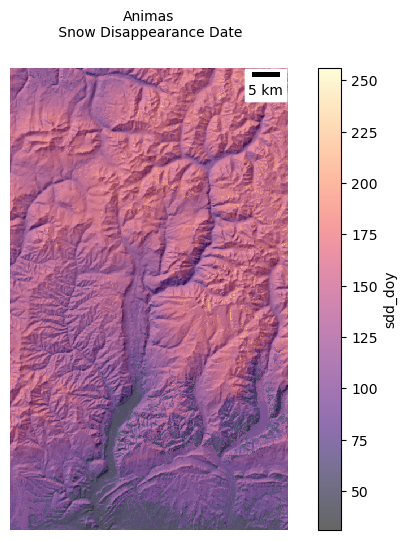

In [25]:
alpha = 0.6
fig, ax = plt.subplots(1, figsize=(8,6))
h.plot_one(hs_crop, cmap='gray', figsize=(4, 5), cbaron=False, turnoffframe=True, specify_ax=(fig, ax))
h.plot_one(sdd_date_ds['sdd_doy'], cmap='magma', figsize=(4, 5), title=f'{basin.capitalize()}\n Snow Disappearance Date', turnoffframe=True, alpha=alpha, specify_ax=(fig, ax))
